In [1]:
# Create proper train/validation/test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pandas as pd

## Load data

In [2]:
# If you are using the automated dataset
df = pd.read_csv("../data/hand_landmarks_dataset_normalized_to_the_wrist.csv")

In [3]:
df

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y16,x17,y17,x18,y18,x19,y19,x20,y20,label
0,0.0,0.0,0.078479,0.003479,0.164516,-0.055302,0.189214,-0.125489,0.176322,-0.192467,...,0.050795,-0.077902,-0.355691,-0.089672,-0.209292,-0.078835,-0.047124,-0.078136,0.039672,1
1,0.0,0.0,0.061821,-0.028920,0.117381,-0.111762,0.101773,-0.194089,0.077751,-0.292142,...,-0.107874,-0.109224,-0.400478,-0.131357,-0.338461,-0.116557,-0.188629,-0.094761,-0.116301,1
2,0.0,0.0,0.092232,-0.040638,0.178110,-0.166931,0.180673,-0.326259,0.129025,-0.441284,...,-0.210975,-0.063017,-0.427073,-0.053517,-0.473683,-0.036248,-0.325759,-0.025089,-0.238332,1
3,0.0,0.0,0.091517,-0.043558,0.164318,-0.191828,0.157139,-0.357856,0.107078,-0.473204,...,-0.225097,-0.042857,-0.412404,-0.038490,-0.475014,-0.025458,-0.333639,-0.015370,-0.257216,1
4,0.0,0.0,0.097081,-0.072745,0.162739,-0.219894,0.149327,-0.387248,0.095536,-0.498102,...,-0.240080,-0.048731,-0.404067,-0.044271,-0.497564,-0.027567,-0.367934,-0.016252,-0.279997,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,0.0,0.0,0.121805,0.116173,0.270006,0.139120,0.392300,0.151042,0.490964,0.209021,...,-0.900155,0.162000,-0.528927,0.199616,-0.725662,0.224168,-0.849913,0.249447,-0.961279,5
904,0.0,0.0,0.125789,0.111121,0.270330,0.135959,0.387052,0.156081,0.483706,0.209586,...,-0.904150,0.154548,-0.515269,0.185476,-0.703811,0.211719,-0.830319,0.241714,-0.943836,5
905,0.0,0.0,0.117736,0.118233,0.255265,0.141987,0.365368,0.150878,0.454374,0.193035,...,-0.904612,0.153192,-0.508453,0.189621,-0.711828,0.219793,-0.842607,0.251906,-0.955347,5
906,0.0,0.0,0.144124,0.107208,0.282320,0.075303,0.385772,0.000600,0.461181,-0.059537,...,-0.862631,0.082639,-0.452491,0.146724,-0.680785,0.183401,-0.835045,0.218750,-0.975781,5


In [4]:
# If you are using the manual dataset
# df = pd.read_csv("../data/hand_landmarks_dataset_normalized_to_the_wrist_manual.csv")

In [5]:
# Separate features and labels
feature_cols = [col for col in df.columns if col != "label"]
X = df[feature_cols].values
y = df["label"].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Convert to categorical
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# Create train/val/test splits (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1,
    random_state=42,
    stratify=y_temp.argmax(axis=1),  # Stratify on class indices
)

input_dim = X.shape[1]

print(f"Classes: {label_encoder.classes_}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Classes: [1 2 3 4 5]
X_train: (653, 42), y_train: (653, 5)
X_val: (73, 42), y_val: (73, 5)
X_test: (182, 42), y_test: (182, 5)


In [6]:
# Save the label encoder for later use in prediction
import joblib

joblib.dump(label_encoder, "../models/label_encoder.pkl")
print("Label encoder saved!")

Label encoder saved!


In [7]:
NUM_CLASSES = len(label_encoder.classes_)

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import json


def create_model(input_dim, num_classes):
    """
    Improved dense model for small feature inputs (42 features).
    """
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=(input_dim,), name="input_layer"),
            # First hidden layer
            tf.keras.layers.Dense(
                128, kernel_initializer="he_normal", name="hidden_1_dense"
            ),
            tf.keras.layers.BatchNormalization(name="hidden_1_batchnorm"),
            tf.keras.layers.Activation("gelu", name="hidden_1_activation"),
            tf.keras.layers.Dropout(0.3, name="hidden_1_dropout"),
            # Second hidden layer
            tf.keras.layers.Dense(
                64, kernel_initializer="he_normal", name="hidden_2_dense"
            ),
            tf.keras.layers.BatchNormalization(name="hidden_2_batchnorm"),
            tf.keras.layers.Activation("gelu", name="hidden_2_activation"),
            tf.keras.layers.Dropout(0.25, name="hidden_2_dropout"),
            # Third hidden layer (smaller, regularized)
            tf.keras.layers.Dense(
                32, kernel_initializer="he_normal", name="hidden_3_dense"
            ),
            tf.keras.layers.BatchNormalization(name="hidden_3_batchnorm"),
            tf.keras.layers.Activation("gelu", name="hidden_3_activation"),
            tf.keras.layers.Dropout(0.2, name="hidden_3_dropout"),
            # Output layer
            tf.keras.layers.Dense(
                num_classes, activation="softmax", name="output_layer"
            ),
        ]
    )

    return model


# Always use categorical_crossentropy for one-hot encoded labels
def compile_model(model):
    """
    Compile model with better optimizer and metrics
    """
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
        loss="categorical_crossentropy",  # Always use this for one-hot encoded labels
        metrics=["accuracy", "precision", "recall"],
    )
    return model


def create_callbacks(model_name="../models/best_model", log_dir="../logs"):
    """
    Create callbacks for better training (with TensorBoard)
    """
    callbacks = [
        # Save best model during training
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.h5",
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
        ),
        # TensorBoard logging
        # tf.keras.callbacks.TensorBoard(
        #     log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True
        # ),
        # Reduce learning rate when stuck
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=10, min_lr=1e-7, verbose=1
        ),
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=20, restore_best_weights=True, verbose=1
        ),
    ]
    return callbacks


def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Train the model with callbacks
    """
    callbacks = create_callbacks()

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
    )

    return history


def plot_training_history(history):
    """
    Plot training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training & validation accuracy
    axes[0, 0].plot(history.history["accuracy"], label="Training Accuracy")
    axes[0, 0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axes[0, 0].set_title("Model Accuracy")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Accuracy")
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot training & validation loss
    axes[0, 1].plot(history.history["loss"], label="Training Loss")
    axes[0, 1].plot(history.history["val_loss"], label="Validation Loss")
    axes[0, 1].set_title("Model Loss")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot precision
    if "precision" in history.history:
        axes[1, 0].plot(history.history["precision"], label="Training Precision")
        axes[1, 0].plot(history.history["val_precision"], label="Validation Precision")
        axes[1, 0].set_title("Model Precision")
        axes[1, 0].set_xlabel("Epoch")
        axes[1, 0].set_ylabel("Precision")
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # Plot recall
    if "recall" in history.history:
        axes[1, 1].plot(history.history["recall"], label="Training Recall")
        axes[1, 1].plot(history.history["val_recall"], label="Validation Recall")
        axes[1, 1].set_title("Model Recall")
        axes[1, 1].set_xlabel("Epoch")
        axes[1, 1].set_ylabel("Recall")
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_test, y_test, class_names=None):
    """
    Comprehensive model evaluation with visualizations saved as separate images
    """
    # Make predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Convert one-hot encoded labels back to integers if needed
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    # Calculate test accuracy
    test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Ensure class_names are strings (fix for the error)
    if class_names is None:
        class_labels = [f"Class {i}" for i in range(len(np.unique(y_true)))]
    else:
        # Convert to strings to avoid the numpy.int64 error
        class_labels = [str(name) for name in class_names]

    # Create output directory for figures
    os.makedirs("../models/evaluation_plots", exist_ok=True)

    # 1. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(
        "../models/evaluation_plots/confusion_matrix.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    # 2. Prediction Confidence Distribution
    plt.figure(figsize=(8, 6))
    max_probs = np.max(y_pred_proba, axis=1)
    plt.hist(max_probs, bins=30, alpha=0.7, edgecolor="black")
    plt.title("Prediction Confidence Distribution")
    plt.xlabel("Max Probability")
    plt.ylabel("Frequency")
    plt.axvline(
        np.mean(max_probs),
        color="red",
        linestyle="--",
        label=f"Mean: {np.mean(max_probs):.3f}",
    )
    plt.legend()
    plt.tight_layout()
    plt.savefig(
        "../models/evaluation_plots/confidence_distribution.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # 3. Class-wise Accuracy
    plt.figure(figsize=(10, 6))
    class_accuracies = []
    for i in range(len(np.unique(y_true))):
        mask = y_true == i
        if np.sum(mask) > 0:
            class_acc = np.mean(y_pred[mask] == y_true[mask])
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0)

    plt.bar(class_labels, class_accuracies, alpha=0.7)
    plt.title("Class-wise Accuracy")
    plt.xlabel("Classes")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(
        "../models/evaluation_plots/class_accuracy.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    # 4. Error Analysis - Top Confused Classes
    plt.figure(figsize=(10, 6))
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    np.fill_diagonal(cm_normalized, 0)  # Remove diagonal (correct predictions)

    # Find top confused pairs
    confused_pairs = []
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            if cm_normalized[i, j] > 0:
                confused_pairs.append((i, j, cm_normalized[i, j]))

    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    top_confused = confused_pairs[:5]  # Top 5 confused pairs

    if top_confused:
        pairs_labels = [
            f"{class_labels[pair[0]]} → {class_labels[pair[1]]}"
            for pair in top_confused
        ]
        confusion_rates = [pair[2] for pair in top_confused]

        plt.barh(pairs_labels, confusion_rates, alpha=0.7)
        plt.title("Top Confused Class Pairs")
        plt.xlabel("Confusion Rate")
    else:
        plt.text(
            0.5,
            0.5,
            "No significant confusion",
            ha="center",
            va="center",
            transform=plt.gca().transAxes,
        )
        plt.title("Top Confused Class Pairs")

    plt.tight_layout()
    plt.savefig(
        "../models/evaluation_plots/confusion_pairs.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    print(f"\nEvaluation plots saved to: ../models/evaluation_plots/")

    return y_pred, y_pred_proba


def save_model_complete(
    model, model_name="my_model", save_history=None, model_info=None
):
    """
    Save model in multiple formats for different use cases
    """
    # Create models directory
    model_dir = "../models"
    os.makedirs(model_dir, exist_ok=True)

    print(f"Saving model to {model_dir}/...")

    # 1. Save complete model in native Keras format (recommended)
    model.save(f"{model_dir}/{model_name}.keras")
    print("✓ Saved complete model (.keras)")

    # 2. Save complete model in H5 format (legacy compatibility)
    try:
        model.save(f"{model_dir}/{model_name}.h5")
        print("✓ Saved complete model (.h5)")
    except Exception as e:
        print(f"⚠ Could not save H5 format: {e}")

    # 3. Save in SavedModel format (for TensorFlow Serving, TensorFlow Lite)
    try:
        model.export(f"{model_dir}/{model_name}_savedmodel")
        print("✓ Saved in SavedModel format")
    except AttributeError:
        # Fallback for older TensorFlow versions
        try:
            tf.saved_model.save(model, f"{model_dir}/{model_name}_savedmodel")
            print("✓ Saved in SavedModel format (fallback method)")
        except Exception as e:
            print(f"⚠ Could not save SavedModel format: {e}")

    # 4. Save only weights (if you want to recreate model architecture separately)
    try:
        model.save_weights(f"{model_dir}/{model_name}.weights.h5")
        print("✓ Saved model weights")
    except Exception as e:
        print(f"⚠ Could not save weights: {e}")
        # Try alternative format
        try:
            model.save_weights(f"{model_dir}/{model_name}_weights")
            print("✓ Saved model weights (alternative format)")
        except Exception as e2:
            print(f"⚠ Could not save weights in any format: {e2}")

    # 5. Save model architecture as JSON
    try:
        model_json = model.to_json()
        with open(f"{model_dir}/{model_name}_architecture.json", "w") as json_file:
            json_file.write(model_json)
        print("✓ Saved model architecture (JSON)")
    except Exception as e:
        print(f"⚠ Could not save architecture JSON: {e}")

    # 6. Save training history if provided
    if save_history:
        try:
            history_dict = {
                k: [float(val) for val in v] for k, v in save_history.history.items()
            }
            with open(f"{model_dir}/{model_name}_history.json", "w") as f:
                json.dump(history_dict, f, indent=2)
            print("✓ Saved training history")
        except Exception as e:
            print(f"⚠ Could not save training history: {e}")

    # 7. Save model information
    if model_info:
        try:
            with open(f"{model_dir}/{model_name}_info.json", "w") as f:
                json.dump(model_info, f, indent=2)
            print("✓ Saved model information")
        except Exception as e:
            print(f"⚠ Could not save model info: {e}")

    # 8. Create a summary file
    with open(f"{model_dir}/README.txt", "w") as f:
        f.write(f"Model: {model_name}\n")
        f.write(f"TensorFlow version: {tf.__version__}\n")
        f.write(f"Files included:\n")
        f.write(
            f"- {model_name}_complete.keras: Complete model (RECOMMENDED for loading)\n"
        )
        f.write(f"- {model_name}_complete.h5: Complete model (legacy H5 format)\n")
        f.write(f"- {model_name}_savedmodel/: TensorFlow SavedModel format\n")
        f.write(f"- {model_name}.weights.h5: Model weights only\n")
        f.write(f"- {model_name}_architecture.json: Model architecture\n")
        f.write(f"- {model_name}_history.json: Training history\n")
        f.write(f"- {model_name}_info.json: Model metadata\n\n")
        f.write("Loading instructions:\n")
        f.write(
            "- Use .keras file: model = tf.keras.models.load_model('path/to/model.keras')\n"
        )
        f.write(
            "- Use .h5 file: model = tf.keras.models.load_model('path/to/model.h5')\n"
        )
        f.write("- Use SavedModel: model = tf.saved_model.load('path/to/savedmodel')\n")

    print(f"✓ Model saved successfully in {model_dir}/")
    return model_dir


def load_saved_model(model_path):
    """
    Load a previously saved model
    """
    try:
        if model_path.endswith(".keras"):
            model = tf.keras.models.load_model(model_path)
        elif model_path.endswith(".h5"):
            model = tf.keras.models.load_model(model_path)
        elif "savedmodel" in model_path.lower():
            model = tf.saved_model.load(model_path)
        else:
            # Try to load as Keras model first
            model = tf.keras.models.load_model(model_path)

        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Please check the file path and format.")
        return None

In [18]:
model = create_model(input_dim=42, num_classes=NUM_CLASSES)  # 21*2 = 42
model = compile_model(model)

In [19]:
# Display model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1_dense (Dense)          │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1_batchnorm              │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1_activation             │ (None, 128)            │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1_dropout (Dropout)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2_dense (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2_batchnorm              │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2_activation             │ (None, 64)             │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2_dropout (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3_dense (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3_batchnorm              │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3_activation             │ (None, 32)             │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3_dropout (Dropout)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,901 (66.02 KB)

 Trainable params: 16,453 (64.27 KB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
history = train_model(model, X_train, y_train, X_val, y_val, epochs=25)

Epoch 1/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2500 - loss: 2.1487 - precision: 0.2500 - recall: 0.0312
Epoch 1: val_accuracy improved from None to 0.27397, saving model to ../models/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3216 - loss: 1.6645 - precision: 0.3907 - recall: 0.0904 - val_accuracy: 0.2740 - val_loss: 1.4567 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5625 - loss: 1.3488 - precision: 0.4545 - recall: 0.1562
Epoch 2: val_accuracy improved from 0.27397 to 0.52055, saving model to ../models/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5743 - loss: 1.2011 - precision: 0.7248 - recall: 0.2420 - val_accuracy: 0.5205 - val_loss: 1.3035 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8125 - loss: 0.8937 - precision: 0.9231 - recall: 0.3750
Epoch 3: val_accuracy improved from 0.52055 to 0.58904, saving model to ../models/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7351 - loss: 0.8849 - precision: 0.9051 - recall: 0.4380 - val_accuracy: 0.5890 - val_loss: 1.1649 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7500 - loss: 0.7155 - precision: 0.8333 - recall: 0.4688
Epoch 4: val_accuracy improved from 0.58904 to 0.68493, saving model to ../models/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7902 - loss: 0.7426 - precision: 0.9396 - recall: 0.5237 - val_accuracy: 0.6849 - val_loss: 1.0369 - val_precision: 1.0000 - val_recall: 0.2192 - learning_rate: 0.0010
Epoch 5/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8438 - loss: 0.5866 - precision: 0.9600 - recall: 0.7500
Epoch 5: val_accuracy improved from 0.68493 to 0.83562, saving model to ../models/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8836 - loss: 0.5925 - precision: 0.9656 - recall: 0.6447 - val_accuracy: 0.8356 - val_loss: 0.9342 - val_precision: 1.0000 - val_recall: 0.2329 - learning_rate: 0.0010
Epoch 6/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9375 - loss: 0.4881 - precision: 0.9583 - recall: 0.7188
Epoch 6: val_accuracy improved from 0.83562 to 0.93151, saving model to ../models/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8943 - loss: 0.4903 - precision: 0.9587 - recall: 0.7473 - val_accuracy: 0.9315 - val_loss: 0.8294 - val_precision: 1.0000 - val_recall: 0.3562 - learning_rate: 0.0010
Epoch 7/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8438 - loss: 0.5614 - precision: 0.9500 - recall: 0.5938
Epoch 7: val_accuracy improved from 0.93151 to 0.94521, saving model to ../models/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9142 - loss: 0.4143 - precision: 0.9662 - recall: 0.7871 - val_accuracy: 0.9452 - val_loss: 0.7537 - val_precision: 1.0000 - val_recall: 0.5479 - learning_rate: 0.0010
Epoch 8/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9062 - loss: 0.4415 - precision: 1.0000 - recall: 0.7812
Epoch 8: val_accuracy did not improve from 0.94521
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9112 - loss: 0.3804 - precision: 0.9640 - recall: 0.8208 - val_accuracy: 0.8904 - val_loss: 0.6633 - val_precision: 1.0000 - val_recall: 0.6575 - learning_rate: 0.0010
Epoch 9/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9062 - loss: 0.2893 - precision: 1.0000 - recall: 0.8750
Epoch 9: val_accuracy did not improve from 0.94521
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9495 - loss: 0.3229 - precision: 0.9759 - recall: 0.8683 - val_accuracy: 0.9452 - val_loss: 0.5711 - val_precision: 1.0000 - val_recall: 0.7808 - learning_rate:

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9571 - loss: 0.2494 - precision: 0.9755 - recall: 0.9142 - val_accuracy: 0.9863 - val_loss: 0.4203 - val_precision: 1.0000 - val_recall: 0.9178 - learning_rate: 0.0010
Epoch 12/25
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9757 - loss: 0.2102 - precision: 0.9776 - recall: 0.9326 
Epoch 12: val_accuracy did not improve from 0.98630
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9786 - loss: 0.2119 - precision: 0.9870 - recall: 0.9311 - val_accuracy: 0.9863 - val_loss: 0.3624 - val_precision: 1.0000 - val_recall: 0.9178 - learning_rate: 0.0010
Epoch 13/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.3101 - precision: 0.9655 - recall: 0.8750
Epoch 13: val_accuracy did not improve from 0.98630
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9525 - loss: 0.2246 - precision: 0.9773 - recall: 0.9250 - val_accuracy: 0.9863 - val_loss: 0.2943 - val_precision: 1.0000 - val_recall: 0.9315 - learning_

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9694 - loss: 0.1790 - precision: 0.9777 - recall: 0.9418 - val_accuracy: 1.0000 - val_loss: 0.2198 - val_precision: 1.0000 - val_recall: 0.9863 - learning_rate: 0.0010
Epoch 15/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0993 - precision: 1.0000 - recall: 1.0000
Epoch 15: val_accuracy did not improve from 1.00000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9786 - loss: 0.1699 - precision: 0.9842 - recall: 0.9510 - val_accuracy: 1.0000 - val_loss: 0.1654 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 16/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.1120 - precision: 1.0000 - recall: 0.9375
Epoch 16: val_accuracy did not improve from 1.00000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9648 - loss: 0.1634 - precision: 0.9762 - recall: 0.9433 - val_accuracy: 1.0000 - val_loss: 0.1468 - val_precision: 1.0000 - val_recall: 1.0000 - learning_r

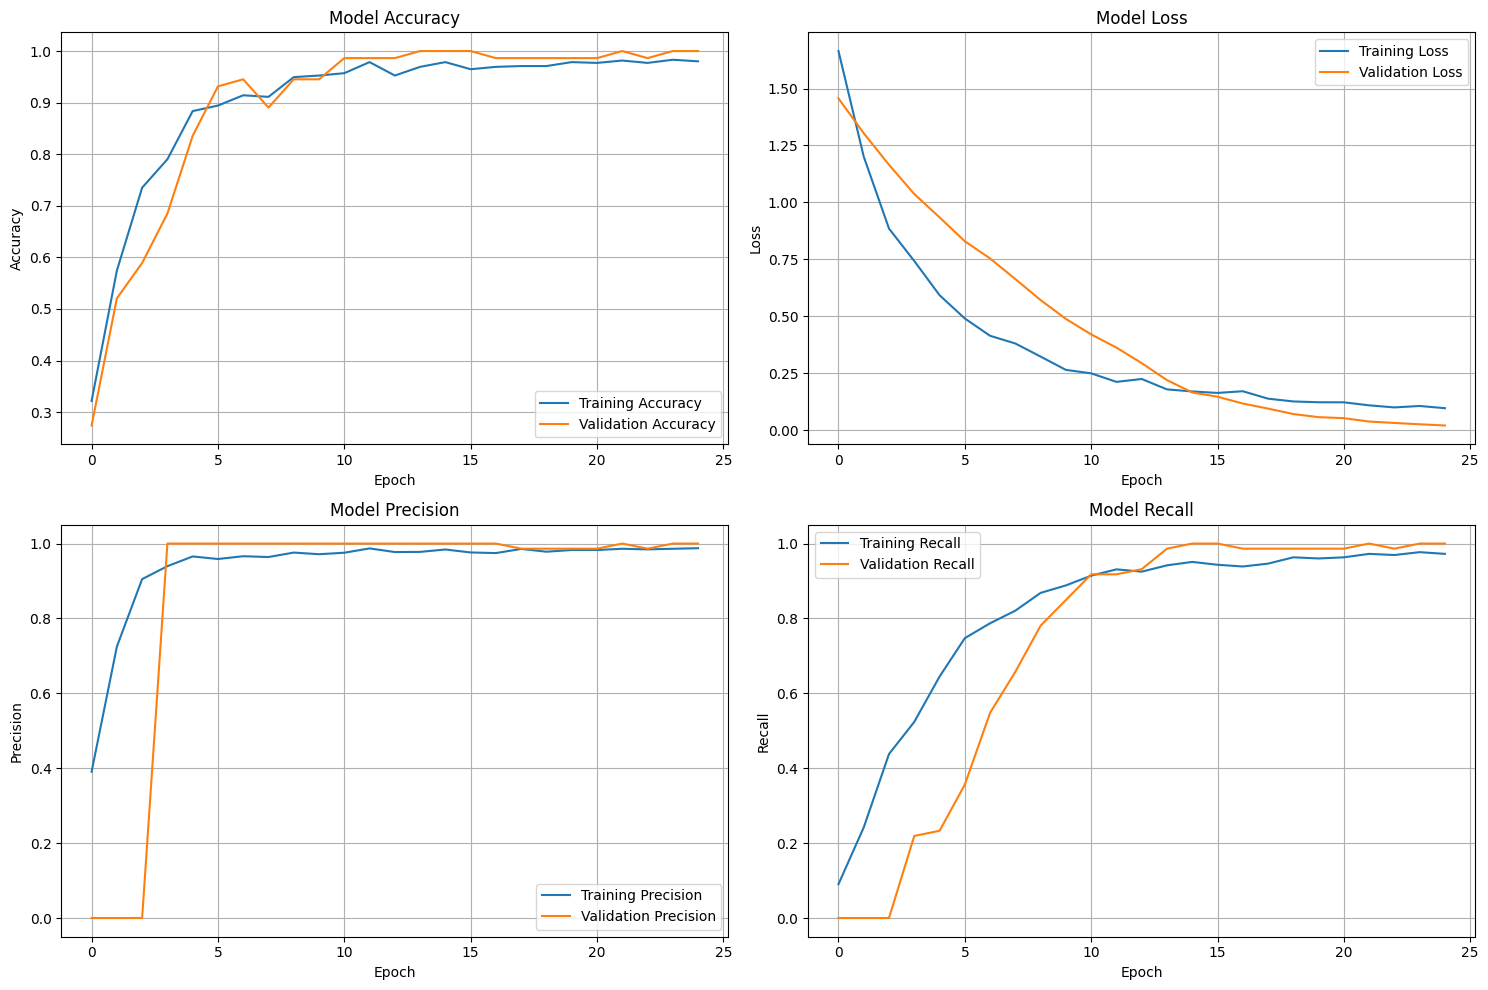

In [21]:
# Visualize training progress
plot_training_history(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test Accuracy: 0.9890


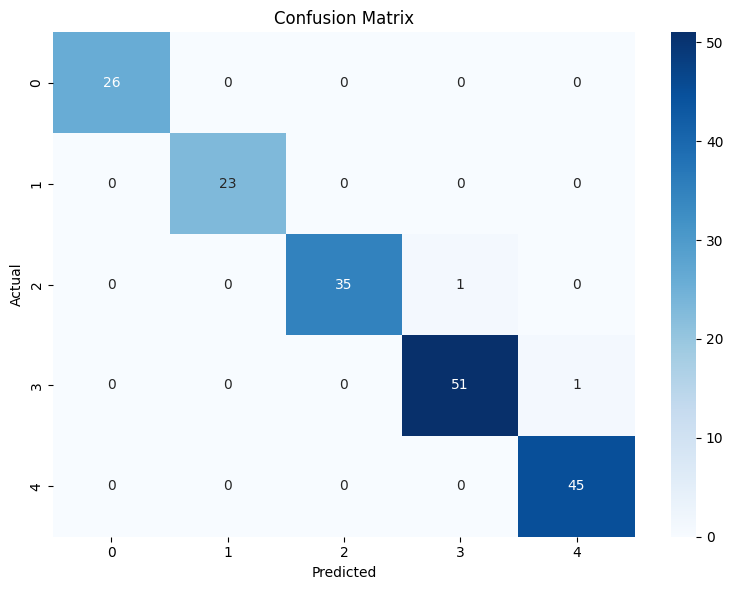

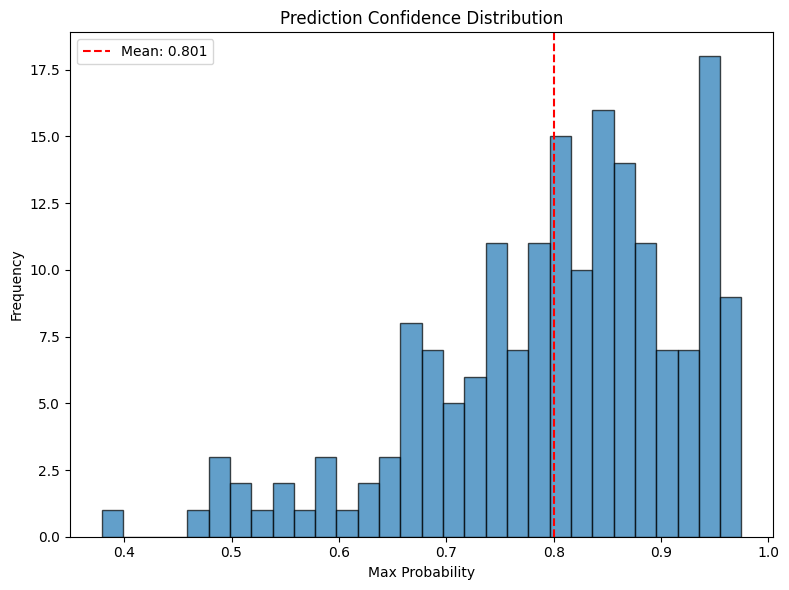

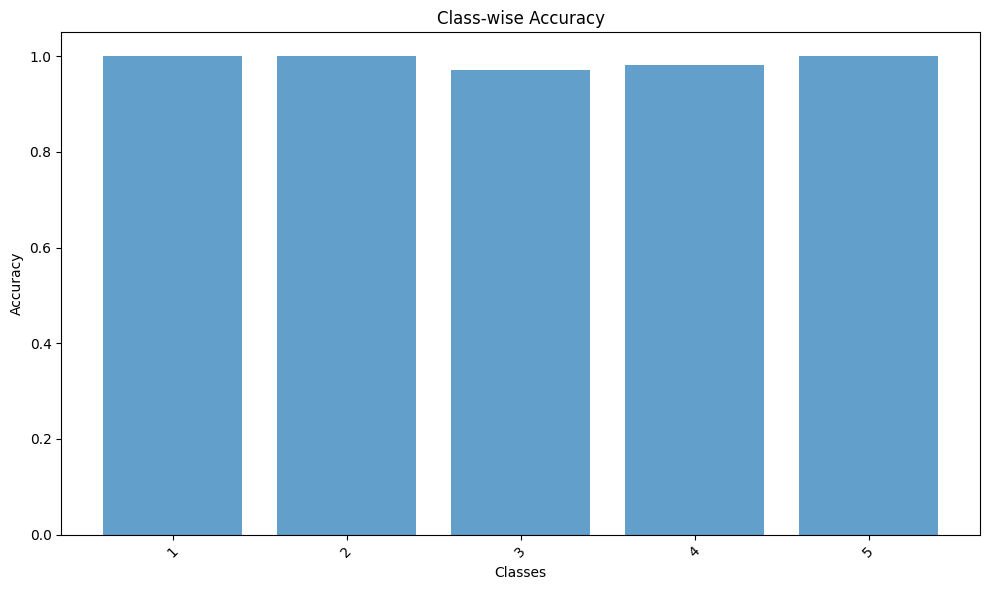

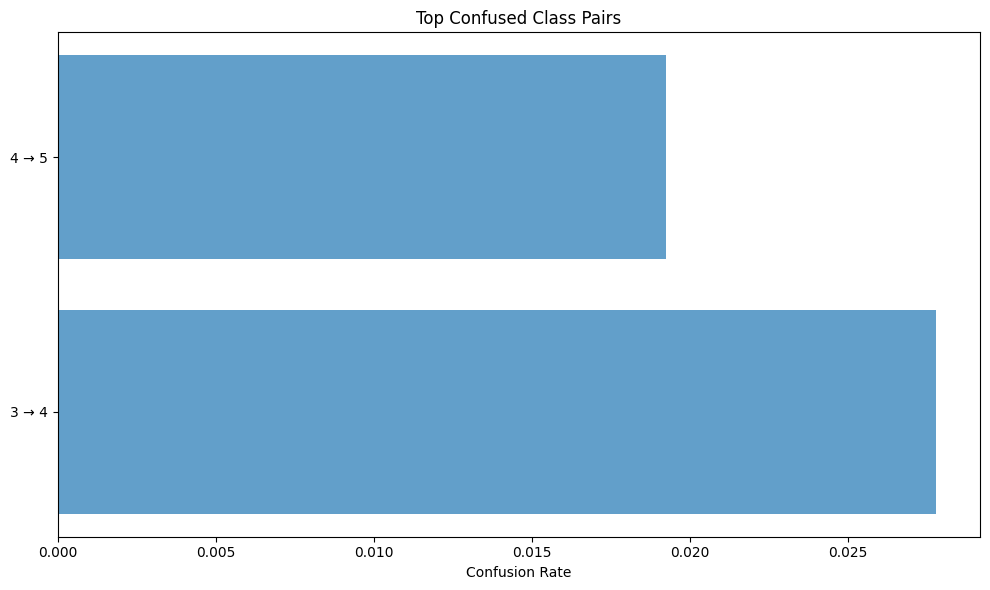


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        23
           3       1.00      0.97      0.99        36
           4       0.98      0.98      0.98        52
           5       0.98      1.00      0.99        45

    accuracy                           0.99       182
   macro avg       0.99      0.99      0.99       182
weighted avg       0.99      0.99      0.99       182


Evaluation plots saved to: ../models/evaluation_plots/


In [22]:
# Evaluate on test set with visualizations
class_names = list(label_encoder.classes_)
y_pred, y_pred_proba = evaluate_model(model, X_test, y_test, class_names)

In [ ]:
# (Optional) Save the figures
def save_plot(filename, folder="plots", dpi=300):
    os.makedirs(folder, exist_ok=True)
    plt.savefig(f"{folder}/{filename}", dpi=dpi, bbox_inches='tight')


In [14]:
# Save the model
# Save with class information
model_info = {
    "input_dim": input_dim,
    "num_classes": num_classes,
    "class_names": label_encoder.classes_.tolist(),
}
save_model_complete(
    model, "gesture_classifier", save_history=history, model_info=model_info
)

model_dir = save_model_complete(
    model, model_name="gesture_classifier", save_history=history, model_info=model_info
)

Saving model to ../models/...
✓ Saved complete model (.keras)
✓ Saved complete model (.h5)
INFO:tensorflow:Assets written to: ../models/gesture_classifier_savedmodel/assets


INFO:tensorflow:Assets written to: ../models/gesture_classifier_savedmodel/assets


Saved artifact at '../models/gesture_classifier_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  5765904720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5765905680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5765905872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5764350416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5765905488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5765906064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5764351376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5764351952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5764351760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5764350800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5765905104: TensorSpec(shape=(), dtype=tf.resource,

✓ Saved in SavedModel format
✓ Saved model weights
✓ Saved model architecture (JSON)
✓ Saved training history
✓ Saved model information
✓ Model saved successfully in ../models/
Saving model to ../models/...
✓ Saved complete model (.keras)
✓ Saved complete model (.h5)
INFO:tensorflow:Assets written to: ../models/gesture_classifier_savedmodel/assets


INFO:tensorflow:Assets written to: ../models/gesture_classifier_savedmodel/assets


Saved artifact at '../models/gesture_classifier_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  5765904720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5765905680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5765905872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5764350416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5765905488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5765906064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5764351376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5764351952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5764351760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5764350800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5765905104: TensorSpec(shape=(), dtype=tf.resource,

In [15]:
# Function to convert you tensorflow model to tensorflow lite
# Since the code is using .tflite model, this step is essential
def convert_model_to_tflite(original_model_path, new_model_name):
    """
    Convert your H5 model to TensorFlow Lite (faster version)
    """
    print("Loading your original model...")
    model = tf.keras.models.load_model(original_model_path, compile=False)

    print("Converting to TensorFlow Lite...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Makes it smaller and faster

    tflite_model = converter.convert()

    # ✅ Ensure directory exists
    os.makedirs(os.path.dirname(new_model_name), exist_ok=True)

    print("Saving new model...")
    with open(new_model_name, "wb") as f:
        f.write(tflite_model)

    print(f"✅ Done! New model saved as: {new_model_name}")
    return new_model_name

In [16]:
# Convert your model
original_path = "../models/gesture_classifier.h5"
new_model_path = "../models/tflite/gesture_classifier.tflite"

convert_model_to_tflite(original_path, new_model_path)

Loading your original model...
Converting to TensorFlow Lite...
INFO:tensorflow:Assets written to: /var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmp7hu29pbo/assets


INFO:tensorflow:Assets written to: /var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmp7hu29pbo/assets


Saved artifact at '/var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmp7hu29pbo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  5767250576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5767264016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5767253648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5767263824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5767263632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5767260560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5767263056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5767262672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5767253840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5767254800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5767254416: TensorSpec(shape=(

W0000 00:00:1758903383.086562 2507175 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758903383.086604 2507175 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1758903383.093405 2507175 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


Saving new model...
✅ Done! New model saved as: ../models/tflite/gesture_classifier.tflite


'../models/tflite/gesture_classifier.tflite'